In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vectorbt as vbt
from sklearn.decomposition import PCA
from scipy.stats import norm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
from metrics import *
from data_preprocessing import * 
from strategy import * 

Стратегия использует динамическую корректировку исходных весов корпоративных облигаций на основе эвристики, учитывающих волатильность и моментум. На обучающем периоде (2018–2022) проводится перебор гиперпараметров для функции adjust_weights с целью максимизации коэффициента Шарпа. Оптимальные параметры затем применяются для расчёта динамических весов на тестовой выборке (2023-...) при построении портфеля.

In [3]:
bonds_filepath = r"../data/cbonds-usa-corporate-index_upd.xlsx"
quotes_filepath = r"../data/quotes_upd.csv"

structure = get_structure(bonds_filepath)
quotes = get_quotes(quotes_filepath, bonds_filepath)

Index Structure checking:
  Index Structure Date                     Issue name          ISIN  \
0           2025-02-01  AT&T Inc, 1.65% 1feb2028, USD  US00206RKG64   
1           2025-02-01  AT&T Inc, 1.7% 25mar2026, USD  US00206RML32   
2           2025-02-01  AT&T Inc, 2.25% 1feb2032, USD  US00206RKH48   
3           2025-02-01   AT&T Inc, 2.3% 1jun2027, USD  US00206RJX17   
4           2025-02-01  AT&T Inc, 2.55% 1dec2033, USD  US00206RMM15   

   Issue amount, USDmn Issue currency Maturity date  
0             2250.000            USD    2028-02-01  
1             3000.000            USD    2026-03-25  
2             2500.000            USD    2032-02-01  
3             2500.000            USD    2027-06-01  
4             3754.161            USD    2033-12-01  
Котировки checking:
  Trade date  Indicative price, %    ACI          ISIN
0 2025-02-07             78.29515  25.20  US68389XBW48
1 2025-02-07             94.44500  26.70  US30231GBK76
2 2025-02-07             97.32000  20.

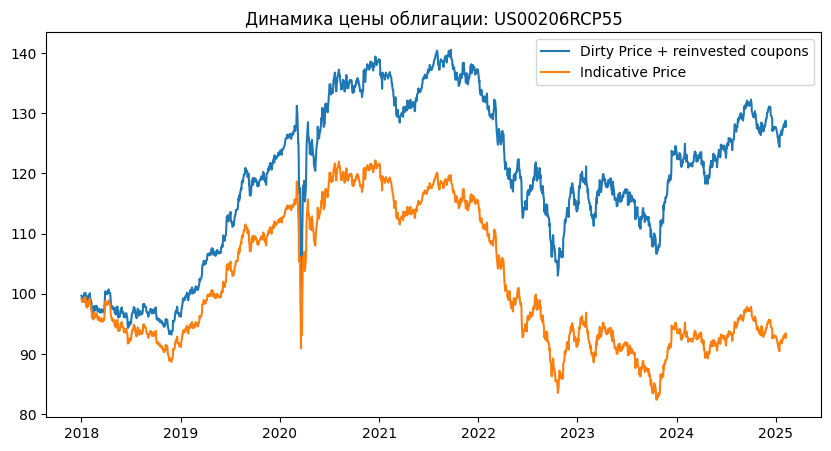

In [4]:
example_isin = "US00206RCP55"
example = quotes[quotes["ISIN"] == example_isin].set_index("Trade date").sort_index()
example["ACI, %"].fillna(0, inplace=True)
coupon_event_ex = example["ACI, %"] > example["ACI, %"].shift(-1)
coupons_ex = example["ACI, %"][coupon_event_ex] + example["ACI, %"].shift(-2)[coupon_event_ex]
coupon_yield_ex = coupons_ex / example["Indicative price, %"]
rets_ex = example["Indicative price, %"].pct_change().fillna(0) + coupon_yield_ex.fillna(0)
price_ex = (1 + rets_ex).cumprod() * example["Indicative price, %"].iloc[0]
price_ex = price_ex.add(example["ACI, %"][~coupon_event_ex], fill_value=0).ffill()

plt.figure(figsize=(10, 5))
plt.plot(price_ex, label="Dirty Price + reinvested coupons")
plt.plot(example["Indicative price, %"], label="Indicative Price")
plt.title(f"Динамика цены облигации: {example_isin}")
plt.legend()
plt.show()

In [5]:
quotes_dirty = calc_dirty_price(quotes)
print("Dirty Price рассчитан для", quotes_dirty["ISIN"].nunique(), "облигаций.")
prices = get_prices(quotes_dirty)
w_aligned = get_weights(structure, quotes_dirty, prices)

Dirty Price рассчитан для 849 облигаций.


In [8]:
train_start = "2018-01-01"
train_end = "2022-12-31"
test_start = "2023-01-01"
commission = 0.001

vol_window_candidates     = [20, 30, 40]
mom_window_candidates     = [90, 120, 150]
vol_threshold_candidates  = [0.1, 0.15, 0.2]
mom_threshold_candidates  = [-0.15, -0.1, -0.05]
best_params, prices_test, adjusted_weights_test = train_model(train_start, train_end, test_start, prices, structure, quotes_dirty, commission, 
                vol_window_candidates,mom_window_candidates, vol_threshold_candidates, mom_threshold_candidates)

Лучшие гиперпараметры по обучающему периоду (2018-2022):
vol_window        40.00000
mom_window       120.00000
vol_threshold      0.20000
mom_threshold     -0.10000
train_sharpe       0.61365
Name: 70, dtype: float64


In [12]:
bond_pf_test = vbt.Portfolio.from_orders(
    close=prices_test,
    size=adjusted_weights_test,
    size_type="targetpercent",
    direction="longonly",
    freq='1D',
    fees=commission,
    cash_sharing=True
)

In [13]:
cbonds_index = pd.read_excel(
    r"../data/cbonds-usa-corporate-index_upd.xlsx",
    sheet_name="index_value",
    index_col=0,
)

pf_returns = bond_pf_test.value().pct_change().fillna(0)
cbonds_index.index = pd.to_datetime(cbonds_index.index)
cbonds_index = cbonds_index.sort_index()
index_prices_test = cbonds_index.loc[test_start:, "Cbonds USA Corporate USD Index"]
index_returns_test = index_prices_test.pct_change().fillna(0)

pf_sharpe = sharpe_ratio(pf_returns)
index_sharpe = sharpe_ratio(index_returns_test)
print(f"Portfolio Sharpe: {pf_sharpe:0.2f}")
print(f"Cbonds Sharpe: {index_sharpe:0.2f}")

total_return, max_dd, calmar = calmar_ratio(pf_returns)
var_5 = calc_var_with_pca(pf_returns)
ipc = calc_ipc(prices_test)

Portfolio Sharpe: 1.05
Cbonds Sharpe: 0.86
Накопленная доходность: 186.73%
Максимальная просадка: -6.42%
Коэффициент Калмара: 29.07
5%-ный VaR портфеля: -0.006068774151192535
Средняя внутрипортфельная корреляция (IPC): 0.35


In [17]:
boot_sharpes = bootstrap_sharpe(pf_returns.dropna(), n_bootstraps=10000)
overfit_probability = np.mean(boot_sharpes > pf_sharpe)
print(f"Вероятность получить лучший шарп на бутстрапированных выборках): {overfit_probability*100:0.2f}%")

Вероятность получить лучший шарп на бутстрапированных выборках): 55.92%
